---

title: **BurnedAreaUAV** Dataset Manual Annotation Analysis

author: Tiago Ribeiro

date: 04/05/2023

---

In [2]:
'~~ Generic usage ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
import os                             # interface with various operating systems
import re                             # regular expression operations
import matplotlib.pyplot as plt       # generate plots
import numpy as np                    # mathematical and matrix operations
import glob                           # find file paths
import base64                         # base64 data decoding
import json                           # JSON file manipulation
import io                             # input/output stream operations
from PIL import Image, ImageDraw      # image manipulation
'~~ Polygon manipulation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
import shapely                        # manipulation of geometric objects
from shapely.geometry import Polygon  # 
from shapely import wkt               # working with *.WKT files
from shapely.affinity import scale    # scale polygons
import geopandas as gpd               # 
from tqdm.auto import tqdm            # progress bar
import cv2                            # computer vision, image manipulation
'~~ Project-specific utilities ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
from utils import polygons_to_mask   # 
from utils import img_b64_to_array   #
from utils import json2data          #        
from utils import labelme_shapes_to_label # 

### Data source paths and directories creation

**note**: to test on your own machine, please set up the paths

In [3]:
DIR = os.getcwd()

# output folders
TEST_DIR = os.path.join(DIR, "data_test")
IMGS_DIR = os.path.join(TEST_DIR, "frames") 
MSCS_DIR = os.path.join(TEST_DIR, "msks")
folders = [MSCS_DIR, IMGS_DIR, TEST_DIR]
# create folders
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# LabelMe annotation file path
JSON_DIR = "E:\BurnedAreaUAV_files\BurnedAreaUAV_dataset\BurnedAreaUAV_dataset\JSON"
TRAIN_JSON = os.path.join(JSON_DIR, "train_valid_json")
TEST_JSON = os.path.join(JSON_DIR, "test_json")

# glob all train json files
json_train = glob.glob(os.path.join(TRAIN_JSON, "*.json"))
json_test = glob.glob(os.path.join(TEST_JSON, "*.json"))
# print found trian and test json files number
print(f"Found {len(json_train)} train json files and {len(json_test)} test json files.")

Found 226 train json files and 23 test json files.


In [8]:
_ = json2data(
    json_dir = TRAIN_JSON,
    out_dir_imgs = IMGS_DIR,
    out_dir_msks = MSCS_DIR)

Converting 226 json files...
Conversion completed. 226 images and respective masks were created.


In [9]:
_ = json2data(
    json_dir = TEST_JSON,
    out_dir_imgs = IMGS_DIR,
    out_dir_msks = MSCS_DIR)

Converting 23 json files...
Conversion completed. 23 images and respective masks were created.


In [4]:
# glob all json files
json_files = sorted(glob.glob(os.path.join(TRAIN_JSON, "*.json")))
json_files += sorted(glob.glob(os.path.join(TEST_JSON, "*.json")))
print(f"Total of json files: {len(json_files)}")

Total of json files: 249


In [5]:
pol = list()
for file in json_files:
    # extract data from json file
    data = json.load(open(file))
    # convert json data to polygons
    pol.append(Polygon(data['shapes'][0]['points']))
    
print(f"Total of polygons: {len(pol)}")

Total of polygons: 249


## First Rule of Consistency

In [6]:
# calculate area of each polygon
area = list()
for i in range(len(pol)): 
    area.append(pol[i].area)

In [7]:
# 5 % tolerance of the value of the last segmentation polygon
alpha = area[-1]*0.05 
# upper and lower limits of the area of the polygons
lim_sup = area[-1] + alpha
lim_inf = area[0] - alpha
ind_area = list()
for i in range(len(area)):
    if (area[i] <= lim_sup and area[i] >= lim_inf) :
        ind_area.append(i)
print(f" {len(ind_area)} chosen frames out of a total of {len(area)}.")

 249 chosen frames out of a total of 249.


## Second Consistency Rule

In [27]:
# Jaccard index
IoU_limiar = pol[0].intersection(pol[-1]).area / pol[0].union(pol[-1]).area
IoU_limiar = IoU_limiar*0.95 # 5% tolerance

In [31]:
# calculates the Jaccard index of each segmentation polygon in relation to p[0]
IoU = list()
for i in range(len(pol)):
    try: 
        IoU.append(pol[0].intersection(pol[i]).area / pol[0].union(pol[i]).area)
    except:
        print(f"Calculation error of IoU of polygons of index {i} and {i+1}")
        IoU.append(0)
# calculates the Jaccard index of each segmentation polygon in relation to p[n]
IoU_fim = list()
for i in range(len(pol)):
    try: 
        IoU_fim.append(pol[-1].intersection(pol[i]).area / pol[-1].union(pol[i]).area)
    except:
        print(f"Calculation error of IoU of polygons of index {i} and {i+1}")
        IoU_fim.append(0)

print (f" From the {len(IoU_fim)} frames, {len(ind_IoU_fim)} were chosen as valid.")

 From the 249 frames, 249 were chosen as valid.


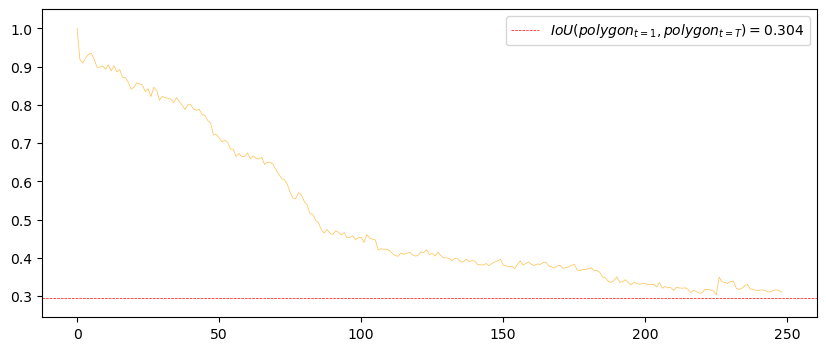

In [33]:
plt.figure(figsize=(10,4))
#plt.title("IoU de todos os poligonos em relacão a p[0]")
plt.plot(np.arange(0, len(IoU)), IoU, linewidth = 0.5, alpha = 0.7,color = "orange")
plt.axhline(IoU_limiar, linestyle='--', linewidth= 0.5, color = "red", label = "$IoU(polygon_{t=1}, polygon_{t=T}) = 0.304$")
#ax1.set_ylim(bottom = 0, top = max(IoU)*1.1)
plt.ylim(bottom = IoU_limiar - 0.05,top = 1.05)
plt.legend();

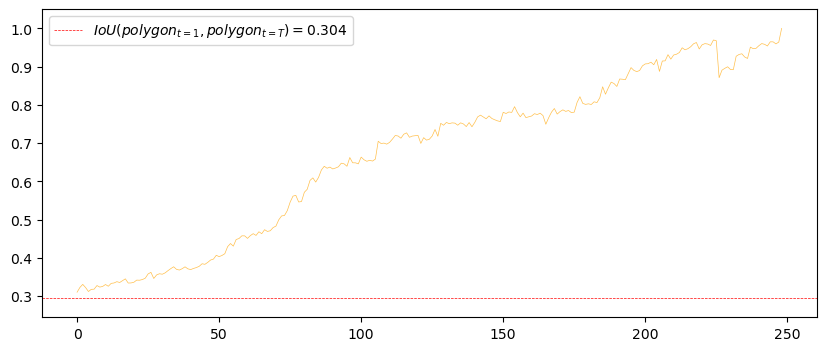

In [35]:
plt.figure(figsize=(10,4))
#plt.title("IoU de todos os poligonos em relacão a p[0]")
plt.plot(np.arange(0, len(IoU_fim)), IoU_fim, linewidth = 0.5, alpha = 0.7, color = "orange")
plt.axhline(IoU_limiar, linestyle='--', linewidth= 0.5, color = "red", label = "$IoU(polygon_{t=1}, polygon_{t=T}) = 0.304$")
#ax1.set_ylim(bottom = 0, top = max(IoU)*1.1)
plt.ylim(bottom = IoU_limiar - 0.05,top = 1.05)
plt.legend();

## Third Consistency Rule

In [40]:
# Calaculate RVI (relative inconsistency value to the initial representation) and
# RVF (relative inconsistency value to the final representation) for all polygons

RVI = list()
RVF = list()
A0 = pol[0].area
An = pol[-1].area
for i in range(len(pol)):
    try: 
        RVIi = ((pol[0].difference(pol[i])).area) / A0
        RVI.append(RVIi)
    except:
        print(f"Erro de cálculo de RVI dos polígonos de indíce {i} e {i+1}")
        RVI.append(1)
    try:
        RVFi = (pol[i].difference(pol[-1]).area) / An
        RVF.append(RVFi)
    except:
        print(f"Erro de cálculo de RVF dos polígonos de indíce {i} e {i+1}")
        RVF.append(1)

teta1 = 0.10
teta2 = 0.10

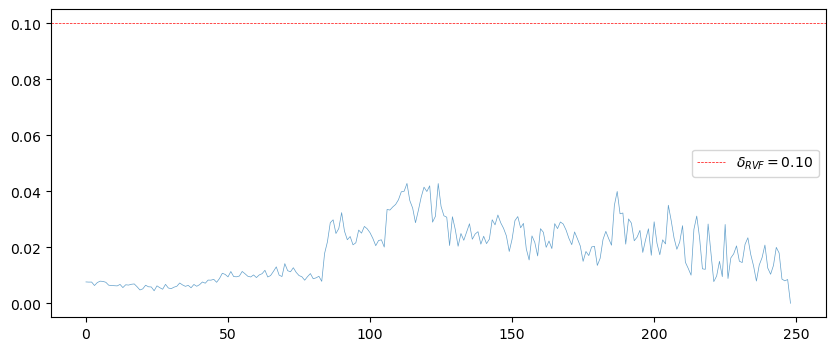

In [42]:
plt.figure(figsize=(10,4))
#plt.title("IoU de todos os poligonos em relacão a p[0]")
plt.plot(np.arange(0, len(RVF)), RVF, linewidth = 0.5, alpha = 0.7)
plt.axhline(teta1, linestyle='--', linewidth= 0.5, color = "red", label = "$\delta_{RVF}= 0.10$")
#ax1.set_ylim(bottom = 0, top = max(IoU)*1.1)
#plt.ylim(bottom = IoU_limiar - 0.05,top = 1.05)
plt.legend();

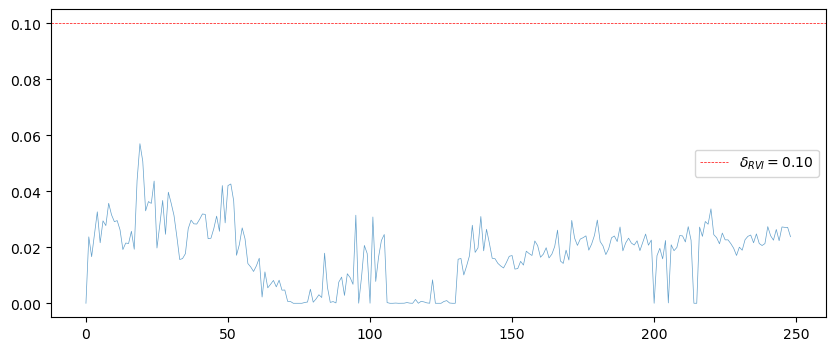

In [47]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(0, len(RVI)), RVI, linewidth = 0.5, alpha = 0.7)
plt.axhline(teta1, linestyle='--', linewidth= 0.5, color = "red", label = "$\delta_{RVI} = 0.10$")
plt.legend()

In [46]:
# choose the indices of the polygons that meet the conditions of RVI and RVF
ind_RVI_RVF = list()
for i in range(len(RVI)):
    if (RVI[i] <= teta1 and RVF[i] <= teta2):
        ind_RVI_RVF.append(i)
print (f" From the {len(RVI)} frames, {len(ind_RVI_RVF)} were chosen as valid.")

 From the 249 frames, 249 were chosen as valid.
